In [1]:
# imports
import numpy as np

# https://arxiv.org/pdf/1706.04599

### What is the point of calibration?

* Ensure that predicted probalitilies match real world outcomes
* I.e. if a nn cannot confidently predict 1 or 0 for obstructions, the car sensor should rely more on the output of other sensors for braking

#### Definitions

Define **perfect calibration** as $ P(\hat{y} = y | \hat{p} = p) = p  $ 

The calibration $\hat{p}=p$ cannot be computed with finitely many samples since $\hat{p}$ is a continuous random variable.

If we have **perfect calibration** then a **reliability diagram** which plots the confidence $\hat{p}$ on the x axis and the accuracy $P(\hat{y} = y | \hat{p} = p)$ on the left should plot the identity function, a diagonal line, $y=x$.

To compute a **reliability diagram**, we bin samples based on their confidence, and calculate the accuracy of each bin, given that we also have $[0,1]$ labels.

In [2]:
"""
generate n x 3 data where 

col_1 is the calibration p, can generate uniformly between (0,1)
col_2 is the label y
col_3 is the predicted label y, so flip col_2 w.p. 1-p

How can we do a bit flip in python?

0 --> 1: 0 + 1 mod 2
1 --> 0: 1 + 1 mod 2

so generate the second operand as a binomial w.p. 1-p
"""

import random

N = 100


def binomialvariate(n,p):
    return sum(random.random() < p for i in range(n))

col_1 = [random.uniform(0,1) for _ in range(N)]
y = [random.randint(0,1) for _ in range(N)]
coin_flip = [binomialvariate(n=1,p=1-proba) for proba in col_1]

y_hat = [(x + y)% 2 for x,y in zip(y,coin_flip)]

data_array = np.array([col_1, y, y_hat])
data_array = data_array.T

In [3]:
# create M = 10 bins for [0,1] interval?
# create list(range(11)) = [0,1,...,9] = buckets 
# each data point is >= lower_bound and < upper_bound

# so if data point is in bucket[i] then data_point >= bucket_[i] and < bucket_[i+1]
# min bucket[i] where data_point is greater than bucket[i]

In [4]:
# sort by col_1, the confidence

# col_1 looks like [0.22, ..., 0.44]
# multiply by 10 then round down
# bucket_assignment = math.floor(item * 10)
import math

bins = [math.floor(item*10) for item in col_1]
# print(bins)

bins = np.array(bins)

idxs = np.argwhere(bins==9)

# col_1, y, y_hat
# data_array ....

accs = []

for bin in range(10):
    idxs = np.argwhere(bins==bin)
    # index into y, y_hat to calculate per bin accuracies
    y_bucket = data_array[idxs,1]
    y_hat_bucket = data_array[idxs,2]

    equals = y_bucket == y_hat_bucket
    acc = np.mean(equals)
    accs.append(acc)

In [5]:
print(accs)

[0.125, 0.1875, 0.35, 0.2, 0.6666666666666666, 0.6, 0.8181818181818182, 0.875, 1.0, 1.0]


In [6]:
buckets = list(range(10))
buckets = [b+0.5 for b in buckets]

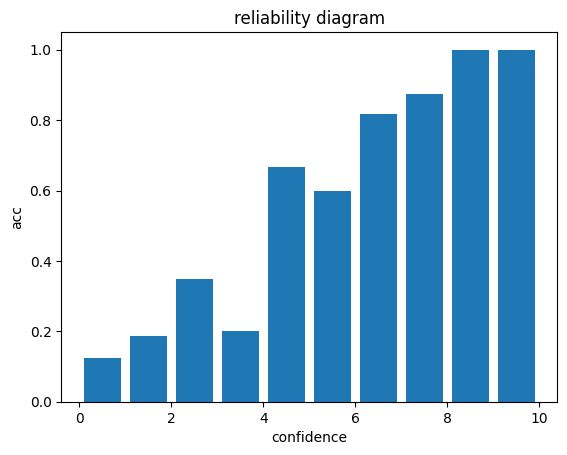

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.bar(buckets, accs, label=buckets)
ax.set_ylabel('acc')
ax.set_xlabel('confidence')
ax.set_title('reliability diagram')

plt.show()

### Expected Calibration Error (ECE)

Prefer to have a scalar over a diagram

$ECE = \mathbb{E}_{\hat{p}} [\lvert P(\hat{y} = y | \hat{p} - p\rvert] = \sum_{m=1}^M \frac{\lvert B_m \rvert}{n} \vert acc(B_m) - conf(B_m) \vert $

In [8]:
# col_conf, y, y_hat
# data_array ....

ece = 0

for bin in range(10):
    idxs = np.argwhere(bins==bin)
    # index into y, y_hat to calculate per bin accuracies
    y_bucket = data_array[idxs,1]
    y_hat_bucket = data_array[idxs,2]

    equals = y_bucket == y_hat_bucket
    acc = np.mean(equals)
    bucket_size = len(idxs)
    conf = np.mean(data_array[idxs,0])
    ece += float(bucket_size/N) * abs(acc-conf)

print(ece)

0.11313762686800219


### What are some ways to calibrate?

NLL, i.e. cross entropy loss, $ - \sum_{p(x)} \log q(x) $ , (Bengio et al 2015). According to (Friedman et al 2001), NLL is minimized iff $\hat{\pi}(y \vert x)$ recovers the ground truth conidtional distribution $\pi(y \vert x)$.

In practice, NLL, diverges from accuracy (Zhang et al 2017) so it is not a great calibration method in practice. 

### Platt Scaling and generalization to MultiClass Problems

What is **Platt scaling** (Platt et al, 1999)?
# https://home.cs.colorado.edu/~mozer/Teaching/syllabi/6622/papers/Platt1999.pdf

* A parametric approach to calibration
* The non-probabilistic predictions of a classifier are used as features for a logistic regression model, which is trained on the validation set to return probabilities
* I.e., learn $\hat{q_i} = \sigma(a z_i + b)$ as the calibrated probability using NLL over the validation set, while the NN parameters are fixed

### Matrix and vector scaling

* two multi-class extensions of Platt scaling. Apply linear transformation before the softmax
* $\hat{q_i} = max_k \sigma_{SM}(W z_i + b)$
* $\hat{y_i'} = argmax_k \sigma_{SM}(W z_i + b)$

* The parameters $W$ and $b$ are optimized wrt to NLL on the validation set.

In [9]:
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [10]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

Files already downloaded and verified


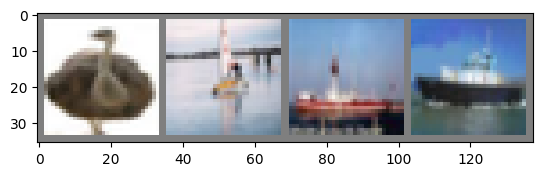

bird  ship  ship  ship 


In [11]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### Define a Convolutional Neural Network


In [12]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [13]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [14]:
for epoch in range(4):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.156
[1,  4000] loss: 1.825
[1,  6000] loss: 1.680
[1,  8000] loss: 1.556
[1, 10000] loss: 1.530
[1, 12000] loss: 1.471
[2,  2000] loss: 1.386
[2,  4000] loss: 1.389
[2,  6000] loss: 1.347
[2,  8000] loss: 1.323
[2, 10000] loss: 1.299
[2, 12000] loss: 1.275
[3,  2000] loss: 1.222
[3,  4000] loss: 1.198
[3,  6000] loss: 1.207
[3,  8000] loss: 1.190
[3, 10000] loss: 1.165
[3, 12000] loss: 1.177
[4,  2000] loss: 1.102
[4,  4000] loss: 1.103
[4,  6000] loss: 1.126
[4,  8000] loss: 1.113
[4, 10000] loss: 1.096
[4, 12000] loss: 1.093
Finished Training


In [15]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [16]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # print(outputs.data.shape)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 59 %


In [17]:
# Freeze params of the CNN

for param in net.parameters():
    param.requires_grad = False

In [38]:
# define a new net, call it PlattNet

class PlattNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.matrix = nn.Linear(10, 10)

    def forward(self, x):
        x = self.matrix(x)
        x = F.softmax(x,dim=1)
        return x

plattnet = PlattNet()

for param in plattnet.parameters():
    param.requires_grad = True

In [39]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(plattnet.parameters(), lr=0.01, momentum=0.9)

In [40]:
for epoch in range(10):  # loop over the validation dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(testloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        outputs = plattnet(outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Calibration')

[1,  2000] loss: 1.982
[1,  4000] loss: 1.906
[1,  6000] loss: 1.891
[1,  8000] loss: 1.892
[1, 10000] loss: 1.886
[2,  2000] loss: 1.870
[2,  4000] loss: 1.872
[2,  6000] loss: 1.874
[2,  8000] loss: 1.889
[2, 10000] loss: 1.874
[3,  2000] loss: 1.860
[3,  4000] loss: 1.867
[3,  6000] loss: 1.863
[3,  8000] loss: 1.885
[3, 10000] loss: 1.873
[4,  2000] loss: 1.858
[4,  4000] loss: 1.863
[4,  6000] loss: 1.861
[4,  8000] loss: 1.871
[4, 10000] loss: 1.869
[5,  2000] loss: 1.851
[5,  4000] loss: 1.860
[5,  6000] loss: 1.859
[5,  8000] loss: 1.866
[5, 10000] loss: 1.868
[6,  2000] loss: 1.851
[6,  4000] loss: 1.857
[6,  6000] loss: 1.854
[6,  8000] loss: 1.866
[6, 10000] loss: 1.865
[7,  2000] loss: 1.850
[7,  4000] loss: 1.857
[7,  6000] loss: 1.849
[7,  8000] loss: 1.866
[7, 10000] loss: 1.867
[8,  2000] loss: 1.846
[8,  4000] loss: 1.853
[8,  6000] loss: 1.851
[8,  8000] loss: 1.873
[8, 10000] loss: 1.867
[9,  2000] loss: 1.848
[9,  4000] loss: 1.856
[9,  6000] loss: 1.850
[9,  8000] 

In [41]:
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False, num_workers=2)

In [22]:
for param in plattnet.parameters():
    param.requires_grad = False

In [23]:
histogram_x = []
histogram_y = []

In [24]:
for epoch in range(1):  # loop over the validation dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(testloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # forward + backward + optimize
        outputs = net(inputs)
        outputs = plattnet(outputs)
        outputs = outputs.detach().numpy()
        labels = labels.detach().numpy()
        histogram_x.append(outputs)
        histogram_y.append(labels)
        

        if i % 1000 == 0: print("data point: ", i)

print('Finished Collecting Calibrated Points')

data point:  0
data point:  1000
data point:  2000
data point:  3000
data point:  4000
data point:  5000
data point:  6000
data point:  7000
data point:  8000
data point:  9000
Finished Collecting Calibrated Points


In [25]:
print(histogram_x[0][0])

[9.6291651e-06 6.6985536e-05 9.4124733e-04 3.4657544e-01 1.1430851e-03
 1.1624161e-02 6.3919026e-01 3.9858798e-05 1.9717305e-04 2.1224306e-04]


In [26]:
res = np.max(histogram_x[0][0])
print(res)

0.63919026


<class 'numpy.ndarray'>
<class 'list'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
[nan, nan, 0.20652173913043478, 0.255, 0.3142857142857143, 0.38968481375358166, 0.4205607476635514, 0.5251727541954591, 0.5594462540716613, 0.8118878005342832]
[0, 0, 0.20652173913043478, 0.255, 0.3142857142857143, 0.38968481375358166, 0.4205607476635514, 0.5251727541954591, 0.5594462540716613, 0.8118878005342832]


/Users/annhe/anaconda3/envs/agency/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/annhe/anaconda3/envs/agency/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


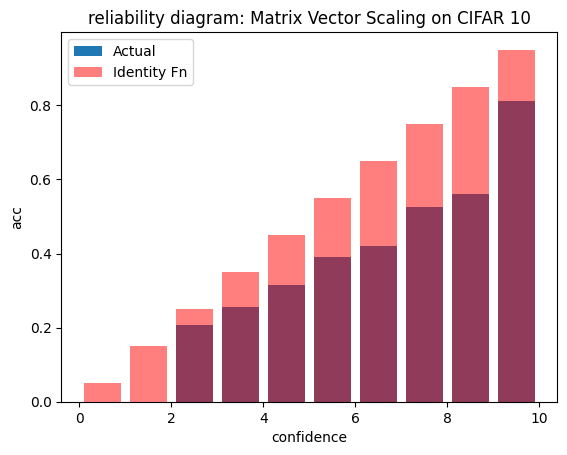

In [27]:
predicted_confidence = [np.max(x[0]) for x in histogram_x]
predicted_class = [np.argmax(x[0]) for x in histogram_x]
y_gt_label = [x[0] for x in histogram_y]

bins = [math.floor(item*10) for item in predicted_confidence]
bins = np.array(bins)
print(type(bins))
print(type(predicted_class))
predicted_class = np.array(predicted_class)
print(type(predicted_class))
y_gt_label = np.array(y_gt_label)
print(type(y_gt_label))

accs = []

for bin in range(10):
    idxs = np.argwhere(bins==bin)
    # print("bin idxs: ", bin, idxs)
    # index into y, y_hat to calculate per bin accuracies
    y_preds = predicted_class[idxs]
    y_gt = y_gt_label[idxs]

    equals = y_preds == y_gt
    acc = np.mean(equals)
    accs.append(acc)

print(accs)
accs = [0 if math.isnan(x) else x for x in accs]
print(accs)

buckets = list(range(10))
buckets = [b+0.5 for b in buckets]
identity = [b*0.1 for b in buckets]

fig, ax = plt.subplots()

ax.bar(buckets, accs, label='Actual')
plt.bar(buckets, identity, color='r', alpha=0.5, label='Identity Fn')
plt.legend()
ax.set_ylabel('acc')
ax.set_xlabel('confidence')
ax.set_title('reliability diagram: Matrix Vector Scaling on CIFAR 10')

plt.show()

### Temperature Scaling

* A single parameter $T > 0$
* Given the logit vector $z_i$, the confidence prediction is $\hat{q_i} = \max_k \sigma_{SM}(z_i/T)$

In [28]:
temperature_x = {}
T_values = [1,2,50,100]
for t_value in T_values:
    temperature_x[t_value] = []

for t_value in T_values:
    for epoch in range(1):  # loop over the validation dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(testloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # forward + backward + optimize
            outputs = net(inputs)
            outputs /= t_value
            # print(outputs.shape)
            outputs = F.softmax(outputs,dim=1)
            #outputs = plattnet(outputs)
            outputs = outputs.detach().numpy()
            #labels = labels.detach().numpy()
            temperature_x[t_value].append(outputs)
            #histogram_y.append(labels)
        

        if i % 100 == 0: print("data point: ", i)

print('Finished Collecting Calibrated Points')

Finished Collecting Calibrated Points


[nan, 0.2236842105263158, 0.27450980392156865, 0.3347763347763348, 0.44606060606060605, 0.5352635486265775, 0.6288848263254113, 0.6938144329896907, 0.8159831756046267, 0.9261363636363636]
[0, 0.2236842105263158, 0.27450980392156865, 0.3347763347763348, 0.44606060606060605, 0.5352635486265775, 0.6288848263254113, 0.6938144329896907, 0.8159831756046267, 0.9261363636363636]


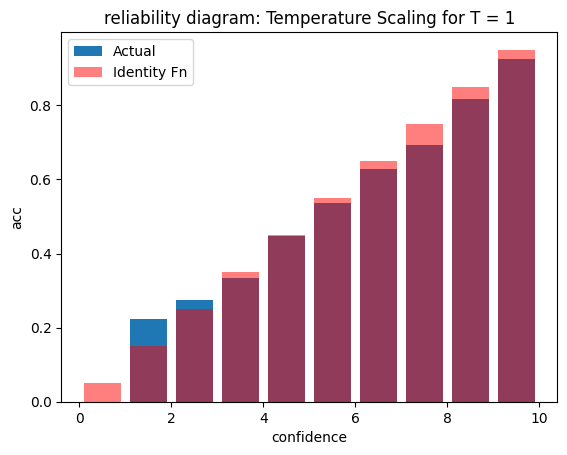

[nan, 0.2662251655629139, 0.39116494478090486, 0.5436849253055681, 0.6849498327759197, 0.8002081165452654, 0.875, 0.9143426294820717, 0.9490616621983914, 0.9823008849557522]
[0, 0.2662251655629139, 0.39116494478090486, 0.5436849253055681, 0.6849498327759197, 0.8002081165452654, 0.875, 0.9143426294820717, 0.9490616621983914, 0.9823008849557522]


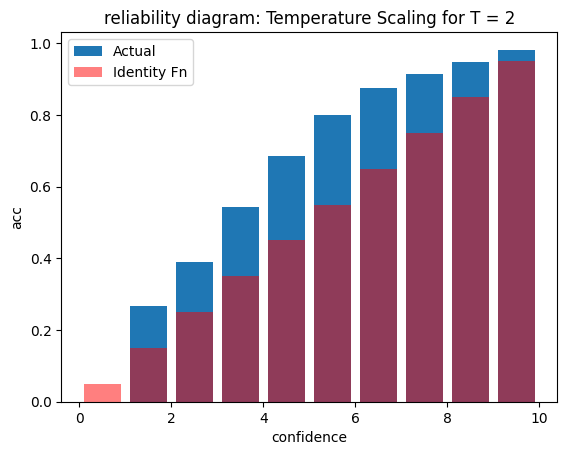

[nan, 0.5916, nan, nan, nan, nan, nan, nan, nan, nan]
[0, 0.5916, 0, 0, 0, 0, 0, 0, 0, 0]


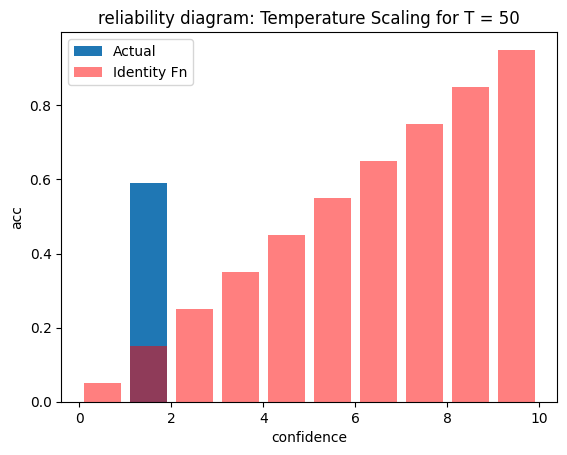

[nan, 0.5916, nan, nan, nan, nan, nan, nan, nan, nan]
[0, 0.5916, 0, 0, 0, 0, 0, 0, 0, 0]


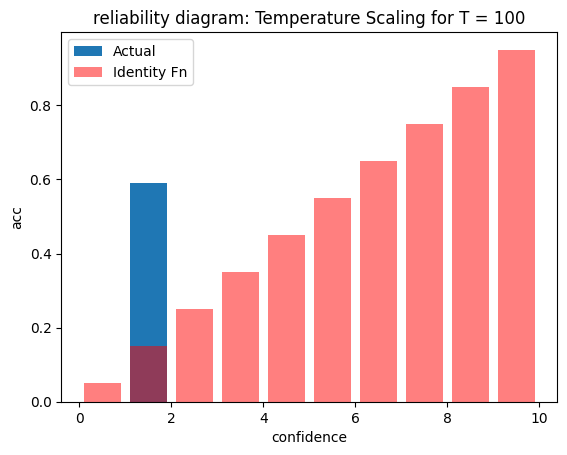

In [29]:
for t_value in T_values:
    histogram_x = temperature_x[t_value]
    
    predicted_confidence = [np.max(x[0]) for x in histogram_x]
    predicted_class = [np.argmax(x[0]) for x in histogram_x]

    bins = [math.floor(item*10) for item in predicted_confidence]
    bins = np.array(bins)
    predicted_class = np.array(predicted_class)

    accs = []

    for bin in range(10):
        idxs = np.argwhere(bins==bin)
        # print("bin idxs: ", bin, idxs)
        # index into y, y_hat to calculate per bin accuracies
        y_preds = predicted_class[idxs]
        y_gt = y_gt_label[idxs]

        equals = y_preds == y_gt
        acc = np.mean(equals)
        accs.append(acc)

    print(accs)
    accs = [0 if math.isnan(x) else x for x in accs]
    print(accs)

    buckets = list(range(10))
    buckets = [b+0.5 for b in buckets]
    identity = [b*0.1 for b in buckets]

    fig, ax = plt.subplots()

    ax.bar(buckets, accs, label='Actual')
    plt.bar(buckets, identity, color='r', alpha=0.5, label='Identity Fn')
    plt.legend()
    ax.set_ylabel('acc')
    ax.set_xlabel('confidence')
    ax.set_title(f'reliability diagram: Temperature Scaling for T = {t_value}')

    plt.show()

In [30]:
# define a new net, call it TemperatureNet

class TemperatureNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.temperature = torch.nn.Parameter(torch.tensor(1.))
        self.register_parameter(name='temperature', param=torch.nn.Parameter(torch.tensor(1.)))

    def forward(self, x):
        x = x * self.temperature
        x = F.softmax(x,dim=1)
        return x

tempnet = TemperatureNet()

print(list(tempnet.parameters()))

for param in tempnet.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(tempnet.parameters(), lr=0.001, momentum=0.9)

[Parameter containing:
tensor(1., requires_grad=True)]


In [31]:
for epoch in range(3):  # loop over the validation dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(testloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        outputs = tempnet(outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Calibration')

[1,  2000] loss: 1.896
[1,  4000] loss: 1.880
[1,  6000] loss: 1.872
[1,  8000] loss: 1.886
[1, 10000] loss: 1.879
[2,  2000] loss: 1.864
[2,  4000] loss: 1.869
[2,  6000] loss: 1.866
[2,  8000] loss: 1.882
[2, 10000] loss: 1.876
[3,  2000] loss: 1.861
[3,  4000] loss: 1.867
[3,  6000] loss: 1.864
[3,  8000] loss: 1.880
[3, 10000] loss: 1.875
Finished Calibration


In [32]:
for param in tempnet.parameters():
    param.requires_grad = False

In [33]:
tempnet_x = []
tempnet_y = []

In [34]:
for epoch in range(1):  # loop over the validation dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(testloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # forward + backward + optimize
        outputs = net(inputs)
        outputs = tempnet(outputs)
        outputs = outputs.detach().numpy()
        labels = labels.detach().numpy()
        tempnet_x.append(outputs)
        tempnet_y.append(labels)
        

        if i % 1000 == 0: print("data point: ", i)

print('Finished Collecting Calibrated Points')

data point:  0
data point:  1000
data point:  2000
data point:  3000
data point:  4000
data point:  5000
data point:  6000
data point:  7000
data point:  8000
data point:  9000
Finished Collecting Calibrated Points


In [35]:
print(tempnet.temperature)

Parameter containing:
tensor(3.8558)


[nan, nan, 0.2222222222222222, 0.225, 0.25, 0.3303834808259587, 0.37535410764872523, 0.41939890710382516, 0.4296799224054316, 0.6856396866840732]
[0, 0, 0.2222222222222222, 0.225, 0.25, 0.3303834808259587, 0.37535410764872523, 0.41939890710382516, 0.4296799224054316, 0.6856396866840732]


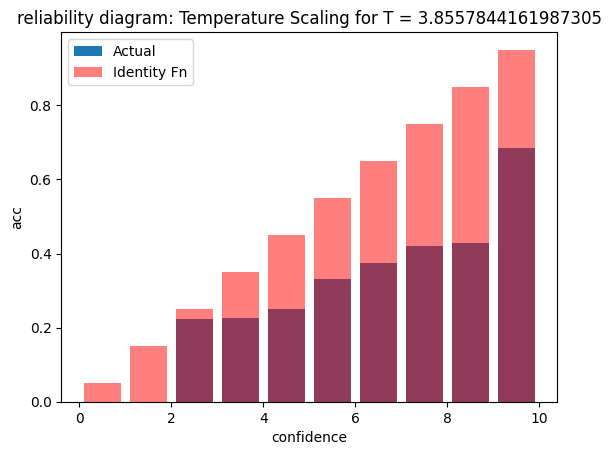

In [36]:
# TODO, final overlaid plots
t_value = tempnet.temperature.detach().numpy()
histogram_x = tempnet_x
predicted_confidence = [np.max(x[0]) for x in histogram_x]
predicted_class = [np.argmax(x[0]) for x in histogram_x]

bins = [math.floor(item*10) for item in predicted_confidence]
bins = np.array(bins)
predicted_class = np.array(predicted_class)

accs = []

for bin in range(10):
    idxs = np.argwhere(bins==bin)
    # print("bin idxs: ", bin, idxs)
    # index into y, y_hat to calculate per bin accuracies
    y_preds = predicted_class[idxs]
    y_gt = y_gt_label[idxs]

    equals = y_preds == y_gt
    acc = np.mean(equals)
    accs.append(acc)

print(accs)
accs = [0 if math.isnan(x) else x for x in accs]
print(accs)

buckets = list(range(10))
buckets = [b+0.5 for b in buckets]
identity = [b*0.1 for b in buckets]

fig, ax = plt.subplots()

ax.bar(buckets, accs, label='Actual')
plt.bar(buckets, identity, color='r', alpha=0.5, label='Identity Fn')
plt.legend()

ax.set_ylabel('acc')
ax.set_xlabel('confidence')
ax.set_title(f'reliability diagram: Temperature Scaling for T = {t_value}')

plt.show()

In [42]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


100%|█████████████████████████████████████████████████| 169001437/169001437 [00:07<00:00, 22977083.81it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [58]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 100)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [59]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [60]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 4.605
[1,  4000] loss: 4.501
[1,  6000] loss: 4.239
[1,  8000] loss: 4.086
[1, 10000] loss: 3.939
[1, 12000] loss: 3.871
[2,  2000] loss: 3.735
[2,  4000] loss: 3.716
[2,  6000] loss: 3.631
[2,  8000] loss: 3.577
[2, 10000] loss: 3.537
[2, 12000] loss: 3.505
[3,  2000] loss: 3.413
[3,  4000] loss: 3.379
[3,  6000] loss: 3.347
[3,  8000] loss: 3.296
[3, 10000] loss: 3.280
[3, 12000] loss: 3.297
[4,  2000] loss: 3.169
[4,  4000] loss: 3.167
[4,  6000] loss: 3.160
[4,  8000] loss: 3.169
[4, 10000] loss: 3.168
[4, 12000] loss: 3.132
[5,  2000] loss: 3.038
[5,  4000] loss: 3.029
[5,  6000] loss: 3.055
[5,  8000] loss: 3.052
[5, 10000] loss: 3.017
[5, 12000] loss: 3.022
[6,  2000] loss: 2.889
[6,  4000] loss: 2.918
[6,  6000] loss: 2.955
[6,  8000] loss: 3.013
[6, 10000] loss: 2.962
[6, 12000] loss: 2.969
[7,  2000] loss: 2.836
[7,  4000] loss: 2.867
[7,  6000] loss: 2.873
[7,  8000] loss: 2.952
[7, 10000] loss: 2.889
[7, 12000] loss: 2.884
[8,  2000] loss: 2.748
[8,  4000] 

KeyboardInterrupt: 

In [ ]:
cifar100_x = []
cifar100_y = []

for epoch in range(1):  # loop over the validation dataset once

    running_loss = 0.0
    for i, data in enumerate(testloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # forward + backward + optimize
        outputs = net(inputs)
        outputs = outputs.detach().numpy()
        labels = labels.detach().numpy()
        cifar100_x.append(outputs)
        cifar100_y.append(labels)
        

        if i % 1000 == 0: print("data point: ", i)

print('Finished Collecting Calibrated Points')

In [54]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

[49 71 23 ... 65 16 14]
[nan, nan, nan, nan, nan, 0.0, 0.07142857142857142, 0.018867924528301886, 0.058091286307053944, 0.18506642235455795]
[0, 0, 0, 0, 0, 0.0, 0.07142857142857142, 0.018867924528301886, 0.058091286307053944, 0.18506642235455795]


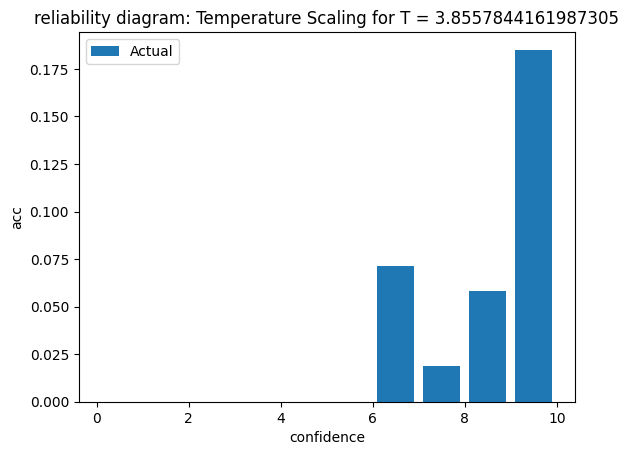

In [56]:
histogram_x = cifar100_x
# need to softmax x
histogram_x = [softmax(x) for x in histogram_x]
predicted_confidence = [np.max(x[0]) for x in histogram_x]
predicted_class = [np.argmax(x[0]) for x in histogram_x]
y_gt_label = [x[0] for x in cifar100_y]
y_gt_label = np.array(y_gt_label)
print(y_gt_label)
#print("predicted confidence: ", predicted_confidence)

bins = [math.floor(item*10) for item in predicted_confidence]
bins = np.array(bins)
predicted_class = np.array(predicted_class)

accs = []

for bin in range(10):
    idxs = np.argwhere(bins==bin)
    # print("bin idxs: ", bin, idxs)
    # index into y, y_hat to calculate per bin accuracies
    y_preds = predicted_class[idxs]
    y_gt = y_gt_label[idxs]

    equals = y_preds == y_gt
    acc = np.mean(equals)
    accs.append(acc)

print(accs)
accs = [0 if math.isnan(x) else x for x in accs]
print(accs)

buckets = list(range(10))
buckets = [b+0.5 for b in buckets]
identity = [b*0.1 for b in buckets]

fig, ax = plt.subplots()

ax.bar(buckets, accs, label='Actual')
#plt.bar(buckets, identity, color='r', alpha=0.5, label='Identity Fn')
plt.legend()

ax.set_ylabel('acc')
ax.set_xlabel('confidence')
ax.set_title(f'reliability diagram: Temperature Scaling for T = {t_value}')

plt.show()

Training a CNN on CIFAR100 because the CNN on CIFAR10 is already well calibrated, and we cannot see the effect of temperature scaling.

Basically the CNN is not being trained well on CIFAR100. So, 

1.  train the CNN properly, adding plots for train and validation, here we are just using test set for validation (usually illegal!): https://github.com/LeoTungAnh/CNN-CIFAR-100/blob/main/CNN_models.ipynb, https://cs231n.github.io/
3.  calculate ECE on the trained net.
4. apply temperature scaling, noting that with torch CE, you get log softmax and nll, so no need to implement softmax in your nn
5. calculate ECE after temperature scaling.